# EnergyDiff

This tutorial explains how EnergyDiff works and how to use EnergyDiff to train a generative model and generate synthetic smart meter data.

---

EnergyDiff is a Denoising Diffusion Probabilistic Model(DDPM)-based model. Unlike traditional VAEs and GANs where seeds are drawn from a normal distribution and decoded through a single-pass in a Neural Network, EnergyDiff works by:
1. Training a denoising diffusion probabilistic model (DDPM) on the real data using MSE loss, which is a simplified Evidence Lower Bound.
2. During inference, draw samples from a latent isotropic Gaussian distribution and decode with the trained model by going through a series of Markovian denoising steps.
3. EnergyDiff has an additional post-processing calibration step to align the marginal distributions. 

For more information on EnergyDiff's architecture, refer to the [EnergyDiff paper](https://arxiv.org/abs/2407.13538).


### Pre-requisites

If you haven't already, please download LCL dataset from [data.london.gov.uk](https://data.london.gov.uk/dataset/smartmeter-energy-use-data-in-london-households). 


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

import logging

logger = logging.getLogger(__name__)

# 💿 Loading LCL Data

In [3]:
from pathlib import Path
from opensynth.data_modules.lcl_data_module import LCLDataModule
import pytorch_lightning as pl

import matplotlib.pyplot as plt

data_path = Path("../../data/processed/historical/train/lcl_data.csv")
stats_path = Path("../../data/processed/historical/train/mean_std.csv")
outlier_path = Path("../../data/processed/historical/train/outliers.csv")

dm = LCLDataModule(data_path=data_path, stats_path=stats_path, batch_size=200, n_samples=20000)
dm.setup()

In [4]:
dm_with_outliers = LCLDataModule(data_path=data_path, stats_path=stats_path, batch_size=200, n_samples=20000, outlier_path=outlier_path)
dm_with_outliers.setup()

# 🤖 Diffusion Module

In [5]:
from opensynth.models.energydiff import diffusion
df_model = diffusion.PLDiffusion1D(
    dim_base=128,
    dim_in=1,
    num_attn_head=4,
    num_decoder_layer=12,
    dim_feedforward=512,
    dropout=0.1,
    learn_variance=False,
    num_timestep=1000,
    model_mean_type=diffusion.ModelMeanType.V,
    model_variance_type=diffusion.ModelVarianceType.FIXED_SMALL,
    loss_type=diffusion.LossType.MSE,
    beta_schedule_type=diffusion.BetaScheduleType.COSINE,
    lr=1e-4,
    ema_update_every=1,
    ema_decay=0.999,
    disable_init_proj=True,
)

/Users/nanlin/miniforge3/envs/opensynth-dev/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# Does not support MPS when InitProjection is used.
# cuda works fine.
# suggested to use cuda to train sufficiently and effcienctly. 

trainer = pl.Trainer(
    gradient_clip_val=1.0,
    gradient_clip_algorithm="norm",
    max_epochs=50,
    accelerator="auto",
)
trainer.fit(df_model, dm_with_outliers)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/nanlin/miniforge3/envs/opensynth-dev/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/Users/nanlin/miniforge3/envs/opensynth-dev/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name            | Type                | Params | Mode 
---------------------------------------------------------

Epoch 0:   0%|          | 0/100 [00:00<?, ?it/s] 

/Users/nanlin/miniforge3/envs/opensynth-dev/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:368: You have overridden `on_before_batch_transfer` in `LightningModule` but have passed in a `LightningDataModule`. It will use the implementation from `LightningModule` instance.


Epoch 1:   4%|▍         | 4/100 [00:02<01:04,  1.48it/s, v_num=1, train_loss_step=0.781, train_loss_epoch=1.130]  


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

### 📦 Track the training dynamics

In [7]:
import pandas as pd
log_dir = trainer.logger.log_dir
metrics = pd.read_csv(f"{log_dir}/metrics.csv")
epoch_train_loss = metrics['train_loss_epoch'].dropna().values
epoch_val_loss = metrics['val_loss'].dropna().values

KeyError: 'val_loss'

NameError: name 'epoch_val_loss' is not defined

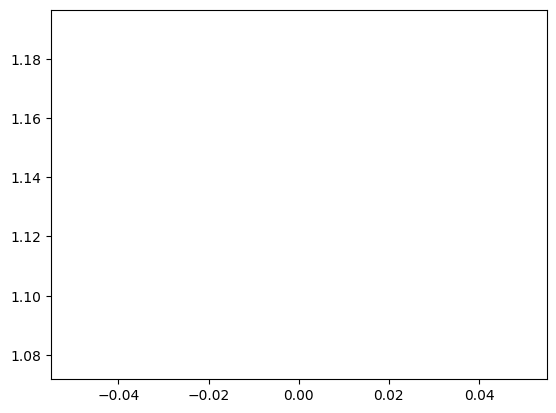

In [8]:
plt.plot(epoch_train_loss, label='Training Loss')
plt.plot(epoch_val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# 📈 Comparing Results

### 0. Generating Samples

In [ ]:
# sample
ema_df_model = df_model.ema.ema_model # GaussianDiffusion1D
dpm_samples = ema_df_model.dpm_solver_sample(total_num_sample=50, batch_size=50, step=100, shape=(48, 1))
dpm_kwh = dm_with_outliers.reconstruct_kwh(dpm_samples.squeeze(-1))
train_kwh = dm_with_outliers.reconstruct_kwh(next(iter(dm_with_outliers.train_dataloader()))['kwh'])

sampling batch 1/1, batch size 50. 


In [ ]:
# calibration
import torch
from opensynth.models.energydiff import calibrate
dpm_kwh_calib = torch.tensor(calibrate.calibrate(train_kwh, dpm_kwh).to('cpu'))

In [ ]:
plt.plot(dpm_kwh_calib.mean(dim=0).cpu().numpy(), label='EnergyDiff')
plt.legend()
plt.show()

In [ ]:
import torch
gmm_data_module = LCLDataModule(data_path=data_path, stats_path=stats_path, batch_size=5000, n_samples=50000, outlier_path=outlier_path) # just to be consistent with Faraday notebook
real_kwh = dm.reconstruct_kwh(next(iter(gmm_data_module.train_dataloader()))[0])
real_kwh = torch.clip(real_kwh, min=0) # Clip min 0 to get read of negative values

### 1. Comparing mean, 95th quantile, median profiles

In [ ]:
def plot_stats(real_kwh, gmm_reconstruct):

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 3), sharey=True, gridspec_kw={'wspace': 0.05})

    ax1.plot(real_kwh.mean(dim=0).detach().numpy(), label="real kwh")
    ax1.plot(gmm_reconstruct.mean(dim=0).detach().numpy(), label="energydiff kwh")
    ax1.set_title("Mean kWh per half hour")
    ax1.set_xlabel("Settlement Periods")
    ax1.legend()

    ax2.plot(real_kwh.quantile(0.95, dim=0).detach().numpy(), label="real kwh")
    ax2.plot(gmm_reconstruct.quantile(0.95, dim=0).detach().numpy(), label="energydiff kwh")
    ax2.set_title("95th Quantile kWh per half hour")
    ax2.set_xlabel("Settlement Periods")
    ax2.legend()

    ax3.plot(real_kwh.quantile(0.5, dim=0).detach().numpy(), label="real kwh")
    ax3.set_title("Median kWh per half hour")
    ax3.set_xlabel("Settlement Periods")
    ax3.plot(gmm_reconstruct.quantile(0.5, dim=0).detach().numpy(), label="energydiff kwh")
    ax3.legend()

    fig.text(0.1, 0.5, 'kWh', va='center', rotation='vertical')

In [ ]:
plot_stats(real_kwh, dpm_samples)

### 2. PCA and TSNE Distribution Plots

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np


def train_pca_and_tsne(real_kwh, gmm_reconstruct):
    pca = PCA(n_components=2)
    tsne = TSNE(n_components=2)

    pca.fit(real_kwh.detach().numpy())
    pca_real = pca.transform(real_kwh.detach().numpy())
    pca_gmm = pca.transform(gmm_reconstruct.detach().numpy())

    tsne_input = np.concatenate([real_kwh.detach().numpy(), gmm_reconstruct.detach().numpy()])
    tsne_results = tsne.fit_transform(tsne_input)
    tsne_real = tsne_results[:len(real_kwh)]
    tsne_gmm = tsne_results[len(real_kwh):]

    return pca_real, pca_gmm, tsne_real, tsne_gmm


def plot_pca_tsne(pca_real, pca_gmm, tsne_real, tsne_gmm):
    fig, (ax_pca, ax_tsne) = plt.subplots(1, 2, figsize=(12, 4))

    ax_pca.scatter(pca_real[:, 0], pca_real[:, 1], label="real kwh", s=0.3, alpha=0.5)
    ax_pca.scatter(pca_gmm[:, 0], pca_gmm[:, 1], label="gmm kwh", s=0.3, alpha=0.5)
    ax_pca.set_title("PCA")
    ax_pca.set_xlabel("PCA 1")
    ax_pca.set_ylabel("PCA 2")
    ax_pca.legend()

    ax_tsne.scatter(tsne_real[:, 0], tsne_real[:, 1], label="real kwh", s=0.3, alpha=0.5)
    ax_tsne.scatter(tsne_gmm[:, 0], tsne_gmm[:, 1], label="gmm kwh", s=0.3, alpha=0.5)
    ax_tsne.set_title("TSNE")
    ax_tsne.set_xlabel("TSNE 1")
    ax_tsne.set_ylabel("TSNE 2")
    ax_tsne.legend()
    return fig


In [ ]:
a1, a2, a3, a4 = train_pca_and_tsne(real_kwh, dpm_samples)
_ = plot_pca_tsne(a1, a2, a3, a4)
plt.title("EnergyDiff")